In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect  

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create session (link) from Python to the DB
session = Session(engine)

In [10]:
 # Use inspector to print the column names types
inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Explore data in Station  
data = engine.execute("SELECT * FROM Station")

for record in data:
    print(record)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


In [13]:
# Query most recent date  
recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_year=datetime.strptime(recent_date[0],'%Y-%m-%d')-dt.timedelta(days=365)
recent_year

datetime.datetime(2016, 8, 23, 0, 0)

In [43]:
# Query to retrieve the last 12 months of precipitation data
precip=session.query(Measurement.prcp, Measurement.date).filter(Measurement.date > recent_year ).order_by(Measurement.date).all()
precip_date=session.query(Measurement.date).filter(Measurement.date > recent_year).order_by(Measurement.date).first()
precip_date1=precip_date[0]

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date columne and sort by date 
prcp_df = pd.DataFrame(precip)
prcp_df.set_index('date', inplace=True)
prcp_df.dropna(how='any', inplace=True)  
prcp_df.sort_values(["date"], ascending=True)
prcp_df.head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


([], <a list of 0 Text xticklabel objects>)

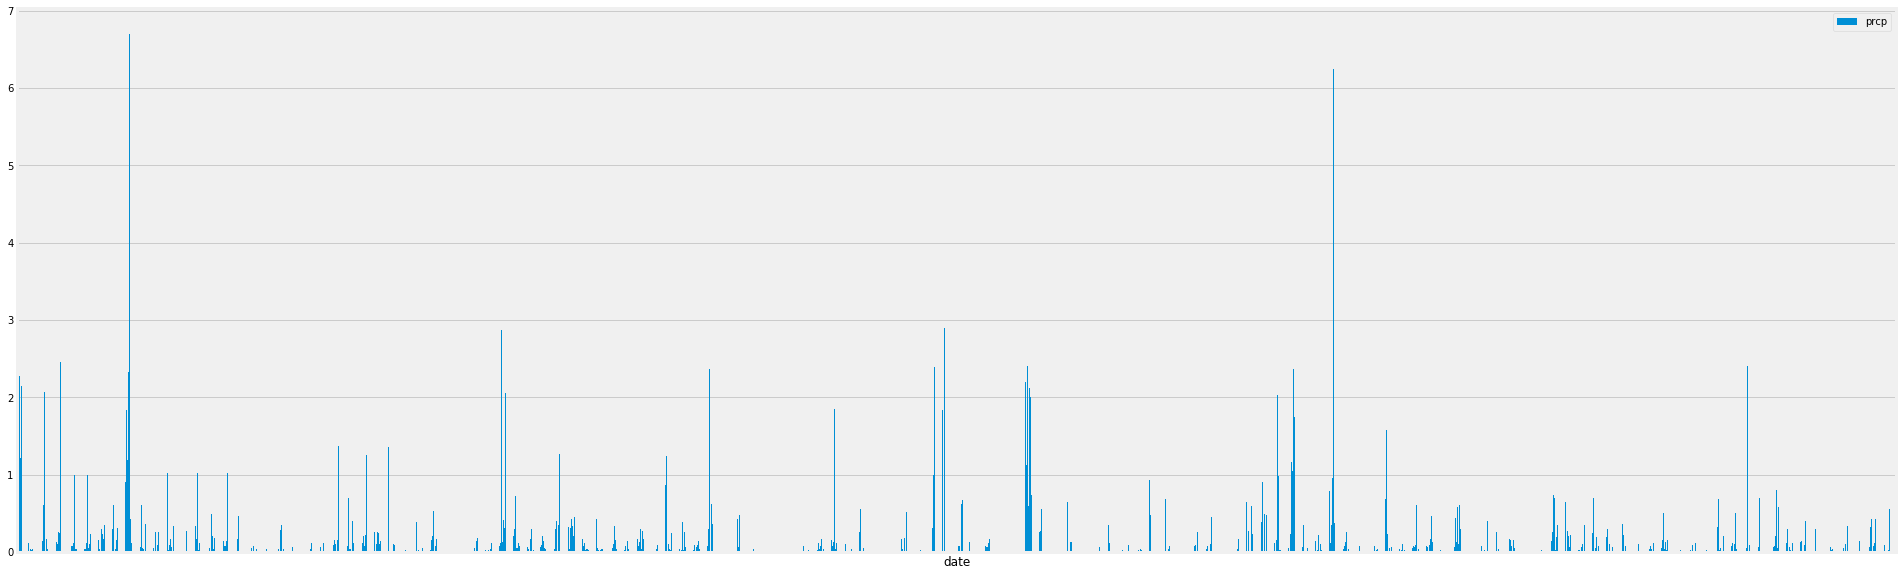

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', figsize=(30,10))
plt.xticks([], [])


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.station).count()

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
active=session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
               order_by(func.count(Measurement.id).desc()).all()
# List the stations and the counts in descending order.
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Isolate most active station 
most_active=active[0][0] 
most_active

'USC00519281'

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded
#and average temperature at the most active station
max_temp=session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
min_temp=session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
avg_temp=session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print("the highest temperature is", max_temp, ", the lowest temperature is", min_temp, ", the average temperature is", avg_temp)

the highest temperature is [(85.0,)] , the lowest temperature is [(54.0,)] , the average temperature is [(71.66378066378067,)]


Text(0.5, 1.0, 'Previous Year Analysis for Station USC00519281')

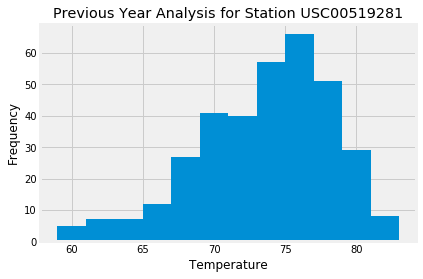

In [44]:
# Choose the station with the highest number of temperature observations.
active_year=session.query(Measurement.tobs).filter(Measurement.station == most_active).\
filter(Measurement.date >precip_date1).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_year_df=pd.DataFrame(active_year)
plt.hist(active_year_df['tobs'],12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Previous Year Analysis for Station " + most_active)



In [45]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [46]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
(calc_temps('2016-05-03', '2016-05-04'))


[(69.0, 74.57142857142857, 78.0)]

([], <a list of 0 Text xticklabel objects>)

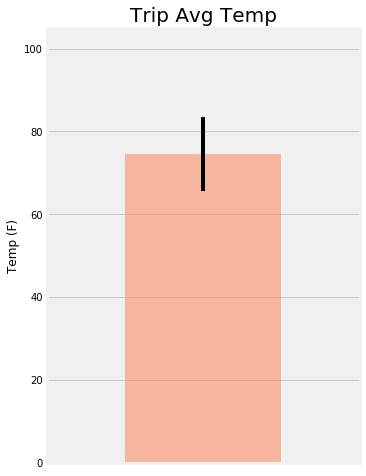

In [47]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip=calc_temps('2016-05-03', '2016-05-04')
trip_df = pd.DataFrame(trip, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
max_min = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=max_min, figsize=(5,8), alpha=0.5, color='coral')
plt.ylim(top=105)
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])

In [48]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rain_per_station = session.query(Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-05-03').\
    filter(Measurement.date <= '2016-05-04').\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(rain_per_station)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.04), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.39), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.31), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.13999999999999999), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.01), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [49]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [50]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2019-05-03'
trip_end = '2019-05-14'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')

# Strip off the year and save a list of %m-%d strings
month_day = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
# push each tuple of calculations into a list called `normals`

normals = []
for date in month_day:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 73.41071428571429, 84.0),
 (65.0, 73.59649122807018, 78.0),
 (67.0, 73.39655172413794, 79.0),
 (66.0, 73.14035087719299, 80.0),
 (64.0, 71.78846153846153, 79.0),
 (65.0, 72.18867924528301, 80.0),
 (67.0, 72.9322033898305, 79.0),
 (64.0, 73.3157894736842, 78.0),
 (65.0, 73.61111111111111, 79.0),
 (65.0, 73.13793103448276, 79.0),
 (67.0, 73.14285714285714, 79.0),
 (63.0, 73.89285714285714, 80.0)]

In [51]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
mma_df = pd.DataFrame(normals, columns=['min temp', 'avg temp', 'max temp'])
mma_df['date'] = trip_dates
mma_df.set_index(['date'],inplace=True)
mma_df.head()

,min temp,avg temp,max temp
date,,,
2019-05-03,67.0,73.410714,84.0
2019-05-04,65.0,73.596491,78.0
2019-05-05,67.0,73.396552,79.0
2019-05-06,66.0,73.140351,80.0
2019-05-07,64.0,71.788462,79.0


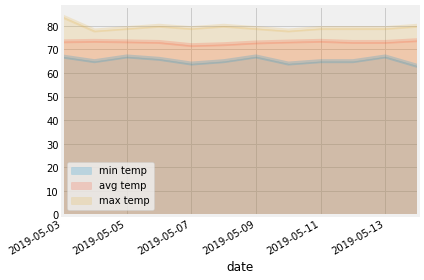

In [52]:
# Plot the daily normals as an area plot with `stacked=False`
mma_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()